# Deep Clustering Tutorial

For this tutorial we assume that you followed the instruction in the [python installation guideline](material/python_installation_guide.txt) and have a running conda installation. 
Additionally, we need the following python packages: numpy, scikit-learn and matplotlib. You can install those in your existing conda environment (make sure that you activated it before installing the packages) via

> ```conda install numpy scikit-learn matplotlib nb_conda jupyter notebook```

We will go through the following topics in this notebook:

1) Implementing a simple autoencoder

2) Applying the autoencoder to MNIST

3) Implementing the deep clustering algorithms DEC/IDEC 


We provide you with a basic implementation of an autoencoder and DEC/IDEC, as well as a more general framework for creating [autoencoders](models/autoencoder_basis.py). Additionally, we have a pretrained autoencoder so you don't have to train it from scratch.

**Note:** You don't need access to an GPU for following this tutorial, but if your laptop is taking too long, you can just use a smaller subset of MNIST (details will be shown below).

--------

In [1]:
# Importing all necessary libraries

# ipython magic functions for automatic reloading code changes in .py files
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict
# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

# specify base paths

base_path = "material"
model_name = "autoencoder.pth"


print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)
print("scikit-learn:", sklearn.__version__)

Versions
torch:  1.6.0
torchvision:  0.7.0
numpy:  1.18.5
scikit-learn: 0.23.2


In [2]:
# some utility functions, you can skip those in the beginning

def denormalize(tensor:torch.Tensor, mean:float=0.1307, std:float=0.3081)->torch.Tensor:
    """
    This applies an inverse z-transformation and reshaping to visualize the mnist images properly.
    """
    pt_std = torch.as_tensor(std, dtype=torch.float32, device=tensor.device)
    pt_mean = torch.as_tensor(mean, dtype=torch.float32, device=tensor.device)
    return (tensor.mul(pt_std).add(pt_mean).view(-1, 1, 28,28) * 255).int().detach()

def plot_images(images:torch.Tensor, pad:int=0):
    """Aligns multiple images on an N by 8 grid"""
    def imshow(img):
        plt.figure(figsize=(10, 20))
        npimg = img.numpy()
        npimg = np.array(npimg)
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)),
                   vmin=0, vmax=1)
    
    imshow(torchvision.utils.make_grid(images, pad_value=255, normalize=False, padding=pad))
    plt.show();
    
def detect_device():
    """Automatically detects if you have a cuda enabled GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

def encode_batchwise(dataloader, model, device):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    for batch in dataloader:
        batch_data = batch[0].to(device)
        embeddings.append(model.encode(batch_data).detach().cpu())
    return torch.cat(embeddings, dim=0).numpy()

def decode_batchwise(dataloader, model, device):
    """ Utility function for decoding the whole data set in a mini-batch fashion
    """
    decodings = []
    for batch in dataloader:
        batch_data = batch[0].to(device)
        decodings.append(model(batch_data).detach().cpu())
    return torch.cat(decodings, dim=0).numpy()

def predict_batchwise(dataloader, model, cluster_module, device):
    """ Utility function for predicting the cluster labels over the whole data set in a mini-batch fashion
    """
    predictions = []
    for batch in dataloader:
        batch_data = batch[0].to(device)
        prediction = cluster_module.prediction_hard(model.encode(batch_data)).detach().cpu()
        predictions.append(prediction)
    return torch.cat(predictions, dim=0).numpy()

def evaluate_batchwise(dataloader, model, cluster_module, device):
    """ Utility function for evaluating the cluster performance with NMI in a mini-batch fashion
    """
    predictions = []
    labels = []
    for batch in dataloader:
        batch_data = batch[0].to(device)
        label = batch[1]
        labels.append(label)
        prediction = cluster_module.prediction_hard(model.encode(batch_data)).detach().cpu()
        predictions.append(prediction)
    predictions = torch.cat(predictions, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return normalized_mutual_info_score(labels, predictions)

------------
# 1) Implementing an autoencoder

In [3]:
class Autoencoder(torch.nn.Module):
    """A vanilla symmetric autoencoder.
    
    Args:
        input_dim: size of each input sample
        embedding_size: size of the inner most layer also called embedding

    Attributes:
        encoder: encoder part of the autoencoder, responsible for embedding data points
        decoder: decoder part of the autoencoder, responsible for reconstructing data points from the embedding    
    """
    def __init__(self, input_dim:int=28*28, embedding_size:int=10):
        super(Autoencoder, self).__init__()
        
        # make a sequential list of all operations you want to apply for encoding a data point
        self.encoder = torch.nn.Sequential(
            # Linear layer (just a matrix multiplication)
            torch.nn.Linear(input_dim, 256),
            # apply an elementwise non-linear function
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(64, embedding_size))
        
        # make a sequential list of all operations you want to apply for decoding a data point
        # In our case this is a symmetric version of the encoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, 64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(128, 256),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(256, input_dim),
            )
    
    def encode(self, x:torch.Tensor)->torch.Tensor:
        """
        Args:
            x: input data point, can also be a mini-batch of points
        
        Returns:
            embedded: the embedded data point with dimensionality embedding_size
        """
        return self.encoder(x)
    
    def decode(self, embedded:torch.Tensor)->torch.Tensor:
        """
        Args:
            embedded: embedded data point, can also be a mini-batch of embedded points
        
        Returns:
            reconstruction: returns the reconstruction of a data point
        """
        return self.decoder(embedded)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        """ Applies both encode and decode function. 
        The forward function is automatically called if we call self(x).
        Args:
            x: input data point, can also be a mini-batch of embedded points
        
        Returns:
            reconstruction: returns the reconstruction of a data point
        """
        embedded = self.encode(x)
        reconstruction = self.decode(embedded)
        return reconstruction

model = Autoencoder(embedding_size=10)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=256, out_features=784, bias=True)
  )
)


-----------------
# 2) Applying the autoencoder to MNIST

## First we have to download the MNIST data set

In [4]:
def load_mnist():
    # setup normalization function
    mnist_mean = 0.1307
    mnist_std = 0.3081
    normalize = torchvision.transforms.Normalize((mnist_mean,), (mnist_std,))
    # download the MNIST data set
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
    data = trainset.data
    # preprocess the data
    # Scale to [0,1]
    data = data.float()/255
    # Apply z-transformation
    data = normalize(data)
    # Flatten from a shape of (-1, 28,28) to (-1, 28*28)
    data = data.reshape(-1, data.shape[1] * data.shape[2])
    labels = trainset.targets
    return data, labels

data, labels = load_mnist()
print("Data Set Information")
print("Number of data points: ", data.shape[0])
print("Number of dimensions: ", data.shape[1])
print(f"Mean: {data.mean():.2f}, Standard deviation: {data.std():.2f}")
print(f"Min: {data.min():.2f}, Max: {data.max():.2f}")
print("Number of classes: ", len(set(labels.tolist())))
print("Class distribution:\n", sorted(Counter(labels.tolist()).items()))

Data Set Information
Number of data points:  60000
Number of dimensions:  784
Mean: -0.00, Standard deviation: 1.00
Min: -0.42, Max: 2.82
Number of classes:  10
Class distribution:
 [(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]


In [5]:
# Optional: Uncomment and run if you want to only use a subsample of MNIST

# subsample_size=10000
# rng = np.random.default_rng()
# idx = rng.choice(data.shape[0], size=subsample_size, replace=False)
# data = data[idx]
# labels = labels[idx]
# print("Data Set Information")
# print("Number of data points: ", data.shape[0])
# print(f"Mean: {data.mean():.2f}, Standard deviation: {data.std():.2f}")
# print(f"Min: {data.min():.2f}, Max: {data.max():.2f}")
# print("Number of dimensions: ", data.shape[1])
# print("Number of classes: ", len(set(labels.tolist())))
# print("Class distribution:\n", sorted(Counter(labels.tolist()).items()))

Plot some images to see if everything worked:


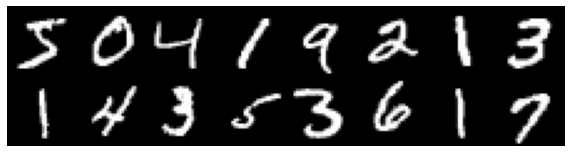

In [6]:
print("Plot some images to see if everything worked:")

plot_images(denormalize(data[0:16]))


## Next we train the autoencoder on MNIST

In [7]:
# Set all parameters needed for training

# The size of the mini-batch that is passed in each trainings iteration
batch_size = 256
# The learning rate specifies the step size of the gradient descent algorithm
learning_rate = 1e-3
# Maximum training iterations
training_iterations = 50000
# Set device on which the model should be trained on (For most of you this will be the CPU)
device = detect_device()
print("Use device: ", device)

# load model to device
model.to(device)

# create a Dataloader to train the autoencoder in mini-batch fashion
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(data, labels)),
                                          batch_size=batch_size,
                                          # sample random mini-batches from the data
                                          shuffle=True,
                                          drop_last=False)

# create a Dataloader to test the autoencoder in mini-batch fashion (Important for validation)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(data, labels)),
                                         batch_size=batch_size,
                                         # Note that we deactivate the shuffling 
                                         shuffle=False,
                                         drop_last=False)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# define loss function
loss_fn = torch.nn.MSELoss()

# path to were we want to save/load the model to/from
pretrained_model_name = "pretrained_" + model_name
pretrained_model_path = os.path.join(base_path, pretrained_model_name)


Use device:  cuda


In [8]:
# Specify if you want to train the model (this will overwrite the existing model)
# or load our already pretrained model:
TRAIN = False

if TRAIN:
    i = 0
    # training loop
    while(i < training_iterations):
        for batch,_ in trainloader:
            # load batch on device
            batch = batch.to(device)
            # reset gradients from last iteration
            optimizer.zero_grad()
            reconstruction = model(batch)
            loss = loss_fn(reconstruction, batch)
            # calculate gradients and reset the computation graph
            loss.backward()
            # update the internal params (weights, etc.)
            optimizer.step()
            if i > training_iterations:
                print("Stop training")
                break
            if i % 1000 == 0:
                print(f"Iteration {i}/{training_iterations} - Reconstruction loss: {loss.item():.4f}")
            i += 1
    # save model
    torch.save(model.state_dict(), pretrained_model_path)
else:
    # load model
    state_dict = torch.load(pretrained_model_path, map_location=device)
    model.load_state_dict(state_dict)
        
    



Original Images


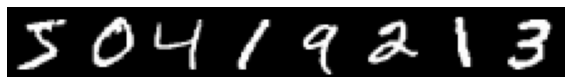

Reconstructed Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


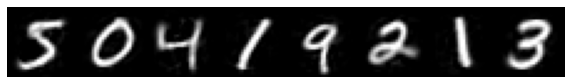

In [9]:
# Plot how well we are at reconstructing the data:
to_plot = 8
print("Original Images")
plot_images(denormalize(data[0:to_plot]))
print("Reconstructed Images")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

## Plotting the embedded space with PCA


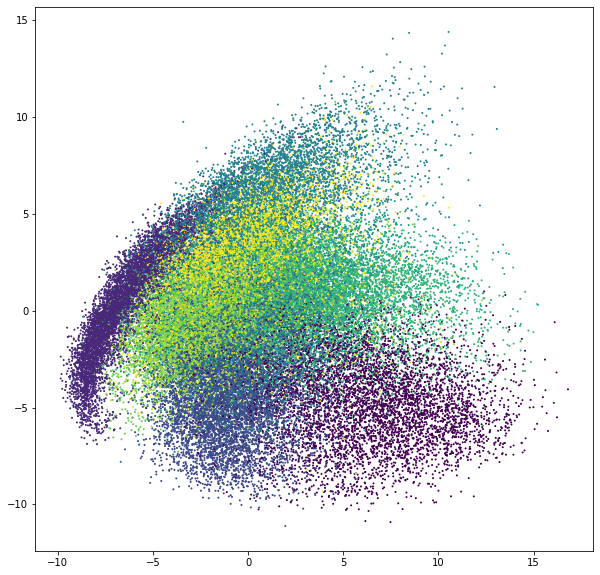

In [10]:
embedded_data = encode_batchwise(testloader, model, device)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embedded_data)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduced_data[:,0], reduced_data[:,1], c=labels, s=1);

-------------------
# Implementing the deep clustering algorithms DEC/IDEC 

Before we get into the details of DEC and IDEC lets see how well a simple baseline like the k-means algorithm performs on our trained autoencoder. K-Means applied on the raw MNIST digits achieves a NMI of about 0.5.

In [11]:
n_clusters = len(set(labels.tolist()))
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embedded_data)
nmi = normalized_mutual_info_score(labels, kmeans.labels_)
print(f"NMI: {nmi:.4f}")

NMI: 0.7325


## Background information about DEC
(We skip this and show directly how to implement DEC)

Deep Embedded Clustering (DEC) is one of the first techniques that simultaneously learns a feature representation and cluster assignments with a deep neural network. The general outline of this technique has inspired further research due to its impressive results. The main contribution of DEC is the formulation of a loss function that quantifies a desirable clustering representation. For this they use the Student's t-distribution, with $\alpha=1$ degrees of freedom, to measure the distance between embedded points $z_i$ and centroids $\mu_j$, see equation $q_{i,j}$. The rationale behind this distribution is that it is heavier tailed than e.g. a gaussian or delta distribution, which allows for similar features to be mapped close together (local structure preservation) and can be evaluated fast, this idea has been adapted from t-sne.

$$
\begin{equation}
q_{i,j} = \frac{(1+\|{z_i-\mu_j}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}{\Sigma_j'(1+\|{z_i-\mu_j'}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}
\label{DEC_SoftAssignment}
\end{equation}
$$

From $q_{i,j}$ they measure the KL Divergence from a desired target distribution $P$:

$$
\begin{equation}
L = KL(P||Q) = \Sigma_i\ \Sigma_j\ p_{i,j}\ \log\frac{p_{i,j}}{q_{i,j}}
\label{KL_DivergenceDEC}
\end{equation}
$$

The authors define the following desirable properties for a target distribution $P$:
 - strengthen predictions
 - put more emphasis on data points assigned with high confidence 
 - normalize loss contribution for each centroid to prevent large clusters from distorting the hidden feature space

$p_{i,j}$ in the equation below fulfills the above properties:

$$
\begin{equation}
p_{i,j} = \frac{\frac{q^2_{i,j}}{f_j}}{\Sigma_{j'} \frac{q^2_{i,j'}}{f_{j'}}}
\label{DEC_P}
\end{equation}
$$

The term $q_{i,j}^2$ strengthens high confidence predictions which leads to improved cluster purity. The term $f_i = \Sigma_i q_{i,j}$ renormalizes by frequency per cluster while summing up the soft cluster frequencies.

DEC uses a previously pretrained autoencoder (as we did above) and then in the following steps the initial clustering is fine tuned to improve the results via backpropagating the gradients from the loss function $L = KL(P||Q)$. This jointly optimizes cluster centers $\mu_j$ and  network parameters $\theta$ until less than a threshold value of $T$ percent of points change their cluster assignment.
 


## Implementation of DEC soft cluster prediction:

$$
\begin{equation}
q_{i,j} = \frac{(1+\|{z_i-\mu_j}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}{\Sigma_j'(1+\|{z_i-\mu_j'}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}
\label{DEC_SoftAssignment}
\end{equation}
$$


In [12]:
def dec_prediction(centers, embedded, alpha=1.0):
    ta = centers.unsqueeze(0)
    tb = embedded.unsqueeze(1)
    squared_diffs = (ta - tb).pow(2).sum(2)
    numerator = (1.0 + squared_diffs / alpha).pow(-1.0 * (alpha + 1.0) / 2.0)
    denominator = numerator.sum(1)
    prob = numerator / denominator.unsqueeze(1)
    return prob

## Implementation of DEC auxiliary target distribution:
$$
\begin{equation}
p_{i,j} = \frac{\frac{q^2_{i,j}}{f_j}}{\Sigma_{j'} \frac{q^2_{i,j'}}{f_{j'}}}
\label{DEC_P}
\end{equation}
$$

In [1]:
def dec_compression_value(pred_labels):
    soft_freq = pred_labels.sum(0)
    squared_pred = pred_labels.pow(2)
    normalized_squares = squared_pred / soft_freq.unsqueeze(0)
    sum_normalized_squares = normalized_squares.sum(1)
    p = normalized_squares / sum_normalized_squares.unsqueeze(1)
    return p

## KL Divergence term:
$$
\begin{equation}
L = KL(P||Q) = \Sigma_i\ \Sigma_j\ p_{i,j}\ \log\frac{p_{i,j}}{q_{i,j}}
\label{KL_DivergenceDEC}
\end{equation}
$$

In [14]:
def dec_compression_loss_fn(q):
    p = dec_compression_value(q).detach().data
    loss = -1.0 * torch.mean(torch.sum(p * torch.log(q + 1e-8), dim=1))
    return loss

## Putting all together in a class

Note the centers $\mu$ and assignments $q$ are jointly learned together

In [15]:
class DEC(torch.nn.Module):
    def __init__(self, init_np_centers, alpha=1.0):
        super().__init__()
        self.alpha = alpha
        # Centers are learnable parameters
        self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)

    def prediction(self, embedded)->torch.Tensor:
        """Soft prediction $q$"""
        return dec_prediction(self.centers, embedded, self.alpha)

    def prediction_hard(self, embedded)->torch.Tensor:
        """Hard prediction"""
        return self.prediction(embedded).argmax(1)

    def loss_dec_compression(self, embedded)->torch.Tensor:
        """Loss of DEC"""
        prediction = dec_prediction(self.centers, embedded, self.alpha)
        loss = dec_compression_loss_fn(prediction)
        return loss

In [16]:
# Load model again
model = Autoencoder()
state_dict = torch.load(pretrained_model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device);

In [17]:
n_rounds = 40000
# Setup DEC
init_centers = kmeans.cluster_centers_
cluster_module = DEC(init_centers).to(device)

# Reduce learning_rate from pretraining by a magnitude of 10
dec_learning_rate = learning_rate*0.1

# Note: We now optimize the autoencoder and the DEC parameters jointly together
optimizer = torch.optim.Adam(list(model.parameters()) + list(cluster_module.parameters()), lr=dec_learning_rate)

# path to were we want to save/load the model to/from

dec_model_name = "dec_" + model_name
dec_model_path = os.path.join(base_path, dec_model_name)
dec_path = os.path.join(base_path, "dec.pth")

In [18]:
TRAIN = False

if TRAIN:
    # DEC Training loop
    i = 0
    while(i < n_rounds):  # each iteration is equal to an epoch
        for batch in trainloader:
            batch_data = batch[0].to(device)
            embedded = model.encode(batch_data)
            reconstruction = model.decode(embedded)

            ae_loss = loss_fn(batch_data, reconstruction)

            cluster_loss = cluster_module.loss_dec_compression(embedded)

            # Reconstruction loss is not included in DEC
            loss = cluster_loss
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 1000 == 0:
                nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
                print(f"{i}/{n_rounds} cluster_loss:{cluster_loss.item():.4f} NMI:{nmi:.4f}"
                      f" Irrelevant for DEC:[ae_loss:{ae_loss.item():.4f} total_loss: {(ae_loss.item() + cluster_loss.item()):.4f}]")

            if i > n_rounds:
                print("Stop training")
                break
            i += 1
    
    # save model
    torch.save(model.state_dict(), dec_model_path)
    # save DEC
    torch.save(cluster_module.state_dict(), dec_path)
else:
    # load model
    state_dict = torch.load(dec_model_path, map_location=device)
    model.load_state_dict(state_dict)
    # load DEC
    state_dict = torch.load(dec_path, map_location=device)
    cluster_module.load_state_dict(state_dict)


nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
print(f"Final NMI:{nmi:.4f}") 
    


Final NMI:0.8292


## Reconstruct again to see what happened by distorting the space with DEC

Original Images


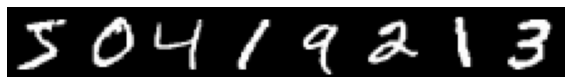

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


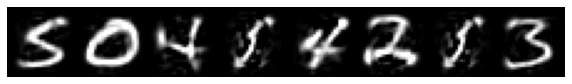

In [19]:
to_plot = 8
print("Original Images")
plot_images(denormalize(data[0:to_plot]))
print("Reconstructed Images")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

## Plot embedded space again with PCA

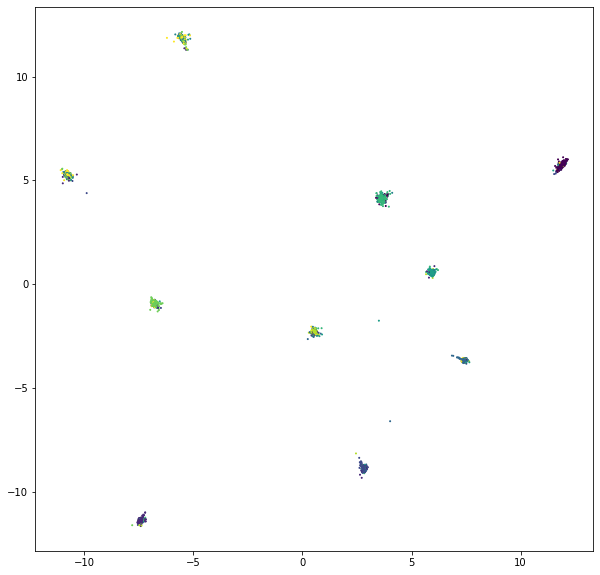

In [20]:
embedded_data = encode_batchwise(testloader, model, device)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embedded_data)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduced_data[:,0], reduced_data[:,1], c=labels, s=1);

# IDEC

One problem of DEC is that during fine tuning the local structure of the embedding can be lost, which weakens its representational power and can decrease clustering performance. This is due to discarding the decoder part of the autoencoder.  The algorithm IDEC suggest a new approach which keeps the decoder part during fine tuning. The new loss function below combines the reconstruction loss $L_r$ and clustering loss $L_c$, where $\gamma>0$ controls the degree of space distortion: 
 
 $$
 \begin{equation}
  L = L_r + \gamma L_c 
 \label{IDEC_LossFunction}
 \end{equation}
 $$
 

In [21]:
# Load model again
model = Autoencoder()
state_dict = torch.load(pretrained_model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device);

In [22]:
n_rounds = 40000
degree_of_space_distortion = 0.1

# Setup IDEC
init_centers = kmeans.cluster_centers_
cluster_module = DEC(init_centers).to(device)

# Reduce learning_rate from pretraining by a magnitude of 10
idec_learning_rate = learning_rate*0.1

# Note: We now optimize the autoencoder and the DEC parameters jointly together
optimizer = torch.optim.Adam(list(model.parameters()) + list(cluster_module.parameters()), lr=idec_learning_rate)

# path to were we want to save/load the model to/from

idec_model_name = "idec_" + model_name
idec_model_path = os.path.join(base_path, idec_model_name)
idec_path = os.path.join(base_path, "idec.pth")

In [23]:
# IDEC Training loop

n_rounds = 40000
train_round_idx = 0
# gamma parameter

TRAIN = False

if TRAIN:
    # IDEC Training loop
    i = 0
    while(i < n_rounds):  # each iteration is equal to an epoch
        for batch in trainloader:
            batch_data = batch[0].to(device)
            embedded = model.encode(batch_data)
            reconstruction = model.decode(embedded)

            ae_loss = loss_fn(batch_data, reconstruction)
            cluster_loss = cluster_module.loss_dec_compression(embedded)
            
            # Reconstruction loss is now included
            # L = L_r + \gamma L_c 
            loss = ae_loss + degree_of_space_distortion * cluster_loss 
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 1000 == 0:
                nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
                print(f"{i}/{n_rounds} cluster_loss:{cluster_loss.item():.4f} NMI:{nmi:.4f}"
                      f" ae_loss:{ae_loss.item():.4f} total_loss: {(ae_loss.item() + cluster_loss.item()):.4f}]")

            if i > n_rounds:
                print("Stop training")
                break
            i += 1
    
    # save model
    torch.save(model.state_dict(), idec_model_path)
    # save IDEC
    torch.save(cluster_module.state_dict(), idec_path)
else:
    # load model
    state_dict = torch.load(idec_model_path, map_location=device)
    model.load_state_dict(state_dict)
    # load IDEC
    state_dict = torch.load(idec_path, map_location=device)
    cluster_module.load_state_dict(state_dict)

nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
print(f"Final NMI:{nmi:.4f}") 

Final NMI:0.8458


## Reconstruct again to see what happened by distorting the space with IDEC

Original Images


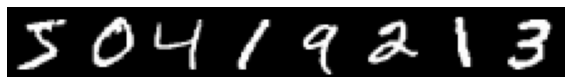

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


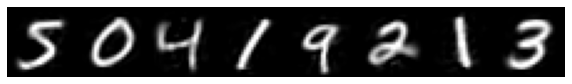

In [24]:
to_plot = 8
print("Original Images")
plot_images(denormalize(data[0:to_plot]))
print("Reconstructed Images")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

## Plot embedded space again with PCA

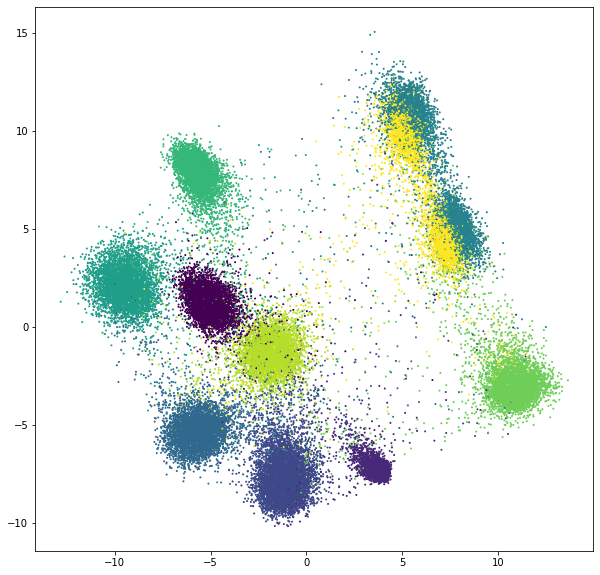

In [25]:
embedded_data = encode_batchwise(testloader, model, device)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embedded_data)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduced_data[:,0], reduced_data[:,1], c=labels, s=1);